# Data Retrieval

In this portion of the pipeline, we're going to selectively retrieve a portion of the data that is clean, and can be used to make significant recommendations to users.


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
%matplotlib inline

First, we're going to load in the database that we populated in the previous notebook, which contains the dataset in fully normalized form. 

In [2]:
conn = sqlite3.connect(":memory:")

with open("dump.sql") as f:
    script = f.read()

cur = conn.cursor()
cur.executescript(script)

In [3]:
def query(query_string, conn=conn):

    cur = conn.cursor()
    cur.execute(query_string)
    
    res = cur.fetchall()
    
    if len(res) > 0:
        
        if len(res[0]) == 1:
            return [x[0] for x in res]
        else:
            return [list(x) for x in res]
        
    return []

    return cur.fetchall()

Just to get a better idea of what data we're working with, we're going to do some exploratory analysis to gain some insights about our dataset.

0.36611326817512385


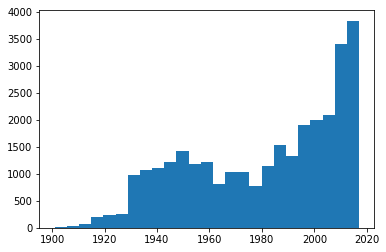

In [4]:
years = query("SELECT year FROM movie")

plt.hist(years, bins=25)
movies_made_after_1977 = len([year for year in years if year >= 2000]) / len(years)
print(movies_made_after_1977)

From this histogram, we can see that the majority of the data falls within the last ~40 years, with 36.6% of movies before produced after 2000. The jump in the 1920s was actually as a result of the release of the first sound film created, The Jazz Singer, and the very inspiring effect it had on the movie industry. As movie techniques got more advanced, different genres of film gained more popularity, and expanded the movie space. These are good things to keep in 

In [5]:
def visualize_ratings(rating):
    
    year_ratings = [list(x) for x in query("SELECT year, {} FROM movie".format(rating))]
    ratings = {}

    for x in year_ratings:

        if x[1] is not None:
            if x[0] not in ratings:
                ratings[x[0]] = 1
            else:
                ratings[x[0]] += 1

    ratings = [[x, ratings[x]] for x in sorted(ratings.keys())]
    years = [x[0] for x in ratings]
    ratings = [x[1] for x in ratings]
    plt.scatter(years, ratings)
    plt.show()

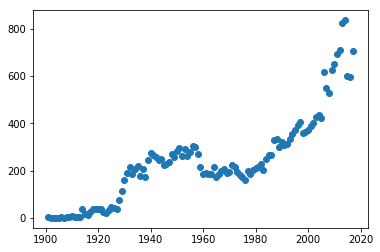

In [6]:
visualize_ratings("imdb_rating")

From this snippet, we can see that the amount of movies that actually have IMDB ratings is relatively low, and in order to make intelligent judgements about recommendations, we want to include movies that have relatively solid IMDB ratings. Let's see if the same trend exists for the metacritic and rotten tomatoes data.

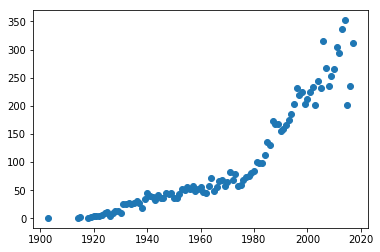

In [7]:
visualize_ratings("rotten_tomato_rating")

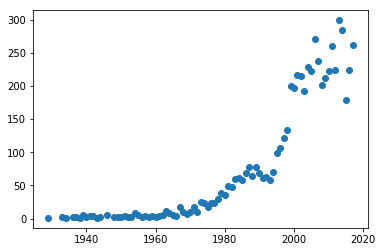

In [8]:
visualize_ratings("metacritic_rating")

# Findings

The same trends in ratings do seem to exist among the different sources of ratings. This supports the decision to probably limit the scope of movies we recommend to those released post, say, 2000. Given that there is minimal training data for movies before this period in terms of ratings, our model would be extrapolating from a region with little to no data, which does not yield very reliable results.

# Creating / Cleaning Dataset

There exist a lot of composite genres in the tables that we created out of the original dataset. Instead of creating dummy codes for each one of these categorical genres, we can create joint dummy codes that more accurately represent the overall genre of a movie. This will give us a more general vector that will allow our recommendation system to generalize more effectively.

For example: 

###### Romantic Comedy

| Romance  | Comedy  | Action  |  Sci-Fi |
|---|---|---|---|
|  1 | 1  |  0 | 0  |


###### Action Romance

| Romance  | Comedy  | Action  |  Sci-Fi |
|---|---|---|---|
|  1 | 0  |  1 | 0  |
   
   
First, we should determine which of the broadest categories we should cater to in order to not pigeonhole our recommendations to rather esoteric genres.

In [9]:
names = query("""
            SELECT name
            FROM movie
            JOIN movie_has_genre ON (movie_has_genre.movie_id = movie.movie_id)
            JOIN genre ON (movie_has_genre.genre_id = genre.genre_id)
            WHERE year >= 2000
            GROUP BY genre.name
            """)

In [10]:
char_list = (" - ", " & ", " / ", "-", "/", "&")
result = []
for name in names:
    for delim in char_list:
        if delim in name:
            for genre in name.split(delim):
                result.append(genre.strip())
            break
        elif (delim == char_list[-1]):
            result.append(name)

[('Satire', 5), ('Sports', 5), ('Sci', 6), ('Social', 6), ('Crime', 7), ('Thriller', 7), ('Mystery', 8), ('Drama', 9), ('Erotic', 9), ('Romance', 9), ('Suspense', 9), ('War', 10), ('Biography', 14), ('History', 16), ('Martial Arts', 16), ('Costume', 17), ('Comedy', 19), ('Horror', 21), ('Musical', 24), ('Children', 33), ('Historical', 34), ('Family', 36), ('Animation', 48), ('Adventure', 54), ('Adult', 90), ('Action', 113), ('Fantasy', 118)]


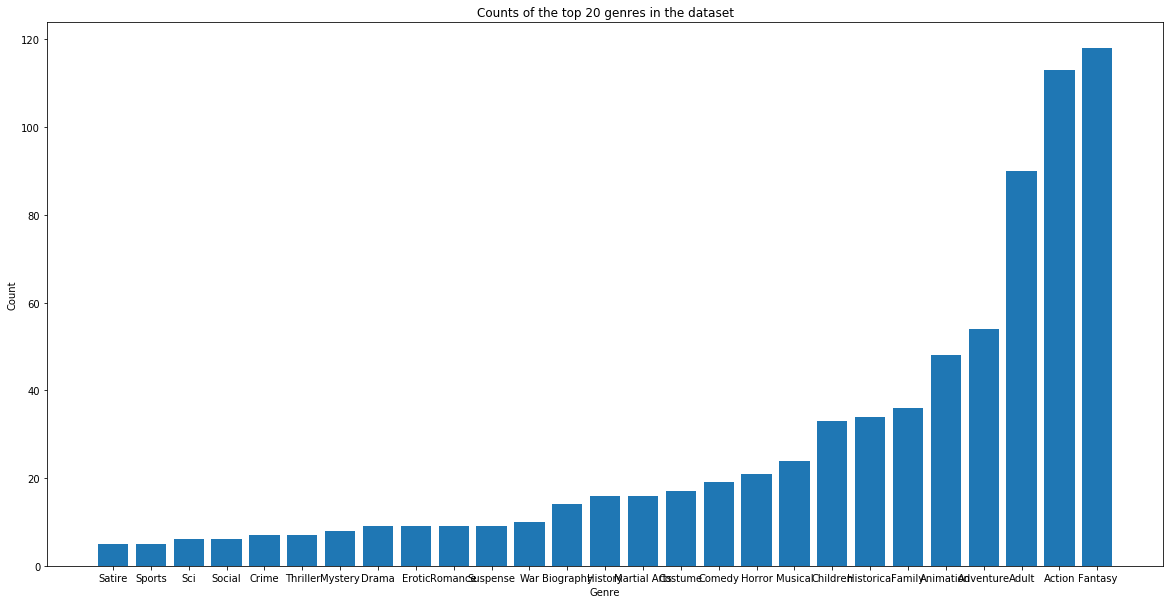

In [11]:
def list_to_dict(input_list):
    
    result = {}
    
    for x in input_list:
        if x in result:
            result[x] += 1
        else:
            result[x] = 1
    return result

def top_k_categories(input_dict, k):
    
    return {word: freq for word, freq in input_dict.items() if freq in sorted(set(input_dict.values()))[-k:]}
    
categories = top_k_categories(list_to_dict(result), 20)

keys = sorted(categories.keys())
vals = [categories[x] for x in categories]

genres = []
hits = []
for key, val in sorted(zip(keys, vals), key=lambda x: x[1]):
    genres.append(key)
    hits.append(val)

plt.figure(figsize=(20,10))
plt.title("Counts of the top 20 genres in the dataset")
plt.ylabel("Count")
plt.xlabel("Genre")
plt.bar(genres, hits)
print(list(zip(genres, hits)))

In order to make our recommendations more robust, we would like to eliminate the outlier genres. We can define the outlier genres to be those that we can cut off while maintaining at least 80% of our genre data. Knowing that 80% of the total data falls within at least one of these genres, the accuracy of this model has a higher probability of being better, since it aims to predict a smaller amount of classes. If we were given more volume of data to work with that had a lot of genre hits for smaller categories, then our model could perform better, and could be incorporated in the future.

In [12]:
total = sum(hits)
perc = 0
GENRE_HIT_THRESHOLD = 0.80
genres_post_filtering = []
for genre, hit in zip(list(reversed(genres)), list(reversed(hits))):
    if (perc < GENRE_HIT_THRESHOLD):
        perc += hit / total
        genres_post_filtering.append(genre)
    else:
        break

In [36]:
learning_dataset = query("""
                        SELECT movie.movie_id, group_concat(genre.name), imdb_rating, metacritic_rating, rotten_tomato_rating 
                        FROM movie
                        JOIN movie_has_genre ON (movie.movie_id = movie_has_genre.movie_id)
                        JOIN genre ON (genre.genre_id = movie_has_genre.genre_id)
                        WHERE year >= 2000
                        AND imdb_rating > 0.5
                        AND metacritic_rating > 0.5
                        AND rotten_tomato_rating > 0.5
                        GROUP BY movie.movie_id, imdb_rating, metacritic_rating, rotten_tomato_rating
                        """)
len(learning_dataset)

2015

In [19]:
col_list = ["movie_id"] + genres_post_filtering + ["imdb_rating", "metacritic_rating", "rotten_tomato_rating"]
df = pd.DataFrame(None, columns=col_list)
df

,movie_id,Fantasy,Action,Adult,Adventure,Animation,Family,Historical,Children,Musical,Horror,Comedy,Costume,imdb_rating,metacritic_rating,rotten_tomato_rating


In [20]:
for row in learning_dataset:
    
    expanded_list = []
    
    for idx, elem in enumerate(row):
        
        if idx != 1:
            expanded_list.append(elem)
        else:
            for genre in genres_post_filtering:
                expanded_list.append(int(genre.lower() in elem.lower()))
            
    df = df.append(pd.DataFrame({key: [val] for key, val in zip(col_list, expanded_list)}), ignore_index=True)

In [21]:
df

,movie_id,Fantasy,Action,Adult,Adventure,Animation,Family,Historical,Children,Musical,Horror,Comedy,Costume,imdb_rating,metacritic_rating,rotten_tomato_rating
0,12877,0,0,0,0,0,1,0,0,0,0,1,0,0.49,0.35,0.31
1,12878,0,0,0,0,0,0,0,0,0,0,0,0,0.60,0.46,0.32
2,12879,0,0,0,0,0,0,0,0,0,0,1,0,0.45,0.11,0.00
3,12880,0,0,0,0,0,0,0,0,0,0,0,0,0.59,0.49,0.41
4,12881,0,0,0,0,0,0,0,0,0,0,0,0,0.58,0.55,0.32
5,12882,0,0,0,0,0,0,0,0,0,0,1,0,0.79,0.90,0.89
6,12883,0,0,0,0,0,0,0,0,0,0,1,0,0.76,0.64,0.68
7,12884,0,0,0,0,0,0,0,0,0,0,0,0,0.66,0.65,0.82
8,12885,0,1,0,0,0,0,0,0,0,0,0,0,0.57,0.30,0.16
9,12886,0,0,0,0,0,0,0,0,0,0,0,0,0.55,0.24,0.19


Since it's the closest thing we have to a proxy for any other rating data, we can impute any missing rating fields with the other ratings. Since they are normalized as well, this makes our results slightly more informative.

In [22]:
def impute_row(row):
    
    ratings = ("metacritic_rating", "rotten_tomato_rating")
    for x in ratings:
        if str(row[x]) == "nan":
            row[x] = (row[[rating for rating in ratings if rating != x][0]] + row["imdb_rating"]) / 2
    return row

df = df.apply(impute_row, axis=1)

In [23]:
df

,movie_id,Fantasy,Action,Adult,Adventure,Animation,Family,Historical,Children,Musical,Horror,Comedy,Costume,imdb_rating,metacritic_rating,rotten_tomato_rating
0,12877,0,0,0,0,0,1,0,0,0,0,1,0,0.49,0.350,0.310
1,12878,0,0,0,0,0,0,0,0,0,0,0,0,0.60,0.460,0.320
2,12879,0,0,0,0,0,0,0,0,0,0,1,0,0.45,0.110,0.000
3,12880,0,0,0,0,0,0,0,0,0,0,0,0,0.59,0.490,0.410
4,12881,0,0,0,0,0,0,0,0,0,0,0,0,0.58,0.550,0.320
5,12882,0,0,0,0,0,0,0,0,0,0,1,0,0.79,0.900,0.890
6,12883,0,0,0,0,0,0,0,0,0,0,1,0,0.76,0.640,0.680
7,12884,0,0,0,0,0,0,0,0,0,0,0,0,0.66,0.650,0.820
8,12885,0,1,0,0,0,0,0,0,0,0,0,0,0.57,0.300,0.160
9,12886,0,0,0,0,0,0,0,0,0,0,0,0,0.55,0.240,0.190


In [26]:
X = df.as_matrix(genres_post_filtering + ["imdb_rating", "metacritic_rating", "rotten_tomato_rating"])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [28]:
from sklearn.cluster import MeanShift

ms = MeanShift()
ms.fit(X)

labels = ms.labels_
num_clusters = len(np.unique(labels))

In [31]:
len(labels)

4823

Deriving this new feature, cluster label will allow us to establish a notion of similarity between records within the dataset we have.